In [1]:
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
import time
from sklearn.neighbors import NearestCentroid
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
class Particle:
    def __init__(self, n_clusters, data, use_kmeans = True, w = 0.72, c1 = 1.49, c2 = 1.49):
        self.n_clusters = n_clusters
        if use_kmeans:
            k_means = KMeans(n_clusters = self.n_clusters)
            k_means.fit(data)
            self.centroids_pos = k_means.cluster_centers_
        else:
            self.centroids_pos = data[np.random.choice(list(range(len(data))),self.n_clusters)]
        
        self.pb_val = np.inf
        self.pb_pos = self.centroids_pos.copy()
        self.velocity = np.zeros_like(self.centroids_pos)
        self.pb_clustering = None
        self.w = w
        self.c1 = c1
        self.c2 = c2
    
        
    def update_pb(self, data: np.ndarray):
        #instanca pripada klasteru, ako je njeno rastojanje od odredjene centroide minimalno
        distances = self._get_distances(data = data)
        clusters = np.argmin(distances, axis = 0)
        clusters_ids = np.unique(clusters)
        
        new_val = self._fitness_function(clusters = clusters, distances = distances)
        if new_val < self.pb_val:
            self.pb_val = new_val
            self.pb_pos = self.centroids_pos.copy()
            self.pb_clustering = clusters.copy()
    
    def update_velocity(self, gb_pos: np.ndarray):
        #azuriramo novu brzinu na osnovu trenutne
        #gb_pos predstavlja niz najboljih pozicija centroida za sve cestice
        
        self.velocity = self.w * self.velocity + \
                        self.c1 * np.random.random() * (self.pb_pos - self.centroids_pos) +\
                        self.c2 * np.random.random() * (gb_pos - self.centroids_pos)
    
    def move_centroids(self, gb_pos, eps):
        self.update_velocity(gb_pos = gb_pos)
        new_pos = self.centroids_pos + self.velocity
        
        old_pos = self.centroids_pos
        self.centroids_pos = new_pos.copy()
        if(abs(np.linalg.norm(new_pos - old_pos, axis = 1)).all() < eps):
            return True
        else:
            return False
    
    def _get_distances(self, data: np.array):
        distances = []
        for centroid in self.centroids_pos:
            d = np.linalg.norm(data - centroid, axis = 1)
            distances.append(d)
        distances = np.array(distances)
        return distances
    
#     def _fitness_function(self, clusters: np.ndarray, distances: np.ndarray):
#         #mse 
#         J = 0.0
#         for i in range(self.n_clusters):
#             p = np.where(clusters == i)[0]
#             if len(p):
#                 d = sum(distances[i][p])
#                 d /= len(p)
#                 for e in p:
#                     J += (distances[i][e]-d)*(distances[i][e]-d)
#         return J

    def _fitness_function(self, clusters: np.ndarray, distances: np.ndarray):
        #sse 
        J = 0.0
        for i in range(self.n_clusters):
            p = np.where(clusters == i)[0]
            if len(p):
                d = sum(distances[i][p]*distances[i][p])
                d /= len(p)
                J += d
        return J
            

In [3]:
class PSOClusteringSwarm:
    def __init__(self, n_clusters: int, n_particles: int, data: np.ndarray, hybrid = True, w = 0.72, c1 = 1.49, c2 = 1.49):
        self.n_clusters = n_clusters
        self.n_particles = n_particles
        self.data = data
    
        self.particles = [] # za cuvanje globalno najboljih
        self.gb_pos = None
        self.gb_val = np.inf
        self.gb_clustering = None
        self.__generate_particles(hybrid, w, c1, c2)
        
    def calculate_sse(self):
        return self.gb_val

    def __generate_particles(self, hybrid:bool, w: float, c1: float, c2: float):
        for i in range(self.n_particles):
            particle = Particle(n_clusters=self.n_clusters, data = self.data, use_kmeans=hybrid, w = w, c1 = c1, c2 = c2)
            self.particles.append(particle)
    
    def update_gb(self, particle):
        if particle.pb_val < self.gb_val:
            self.gb_val = particle.pb_val
            self.gb_pos = particle.pb_pos.copy()
            self.gb_clustering = particle.pb_clustering.copy()
            
    def start(self, iteration = 1000,eps = 1e-5):
        progress = []
        for i in range(iteration):
            
            for particle in self.particles:
                particle.update_pb(data = self.data)
                self.update_gb(particle = particle)

            # promenljiva koja ispituje da li je doslo do konvergencije centroida
            converged = True
            for particle in self.particles:
                if(not particle.move_centroids(gb_pos = self.gb_pos, eps = eps)):
                    converged = False
            progress.append([self.gb_pos, self.gb_clustering, self.gb_val])
            
            if(converged == True):
                break
        
        clusters = self.gb_clustering
        
        return self.gb_clustering, self.gb_val
                        

In [4]:
def convert_to_pca(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    data_scaled_df = pd.DataFrame(data_scaled)
    
    pca = PCA(2)
    data_pca = pca.fit_transform(data_scaled_df)
    data_pca_df = pd.DataFrame(data_pca)

    return data_pca_df.values

In [5]:
def plot_pso(data, pso, duration, num_clusters, swarm_size): 
    centroids = pso.gb_pos
    
    sse, score = calculate_sse_and_silhouette(data, pso.gb_clustering, pso.gb_pos)
    
    if(len(pso.data[0]) > 2):
        data = convert_to_pca(pso.data)
        centroids = convert_to_pca(pso.gb_pos)
        
    plt.scatter(data[:, 0], data[:, 1], c=pso.gb_clustering, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.title(f'SSE = { round(sse,6) },\n Silhouette score = {round(score,6)} \
            \n Duration = {round(duration,6)} \n Clusters = {num_clusters}, Swarm size = {swarm_size}')   

In [6]:
def standardize_data(data):
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data)
        return pd.DataFrame(data_scaled).values

In [7]:
def calculate_sse_and_silhouette(data, labels, centroids):    
    distances = []
    for centroid in centroids:
        d = np.linalg.norm(data - centroid, axis = 1)
        distances.append(d)
        
    distances = np.array(distances)
    clusters = np.argmin(distances, axis = 0)
    
    score = 0
    if(len(np.unique(clusters)) != 1):
        score = silhouette_score(data, labels, metric='euclidean')
    
    sse = 0.0
    for i in range(len(centroids)):
        p = np.where(clusters == i)[0]
        if len(p):
            d = sum(distances[i][p]*distances[i][p])
            d /= len(p)
            sse += d
    
    return sse, score

In [8]:
def start_pso(alg_name, data, n_clusters, n_particles, iterations):
    if alg_name == 'pso':
        alg = PSOClusteringSwarm(n_clusters=n_clusters, n_particles=n_particles, data=data, hybrid=False) 

    if alg_name == 'hybrid-pso':
        alg = PSOClusteringSwarm(n_clusters=n_clusters, n_particles=n_particles, data=data, hybrid=True) 
    
    alg.start(iteration=iterations, eps = 1e-5)
    return alg

In [9]:
def start_k_means(data, n_clusters, max_iter = 1000):
    
    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter)
    kmeans.fit(data)

    score = silhouette_score(data, kmeans.labels_, metric='euclidean')
    
    return kmeans

In [10]:
def plot_k_means(data, kmeans, duration):
    centroids = kmeans.cluster_centers_
    
    sse, score = calculate_sse_and_silhouette(data, kmeans.labels_, kmeans.cluster_centers_)
    
    if(len(data[0]) > 2):
        data = convert_to_pca(data)
        centroids = convert_to_pca(centroids)
    
    n_clusters = kmeans.n_clusters
    max_iter = kmeans.max_iter
    
    plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.title(f'SSE = { round(sse,6) },\n Silhouette score = {round(score,6)} \
            \n Duration = {round(duration,6)} \n Clusters = {n_clusters}, Num of iters = {max_iter}')

In [11]:
def start_agglomerative(data, n_clusters, i):
    
    if i%3 == 1:
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    elif i%3 == 2:
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage="single")
    else:
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    
    model.fit(data)
    
    return model, model.linkage

In [12]:
def plot_agglomerative(data, model, linkage, duration):
    # Za dobijanje centroida  
    pred = model.fit_predict(data)
    clf = NearestCentroid()
    clf.fit(data, pred)
    centroids = clf.centroids_ 
    
    sse, score = calculate_sse_and_silhouette(data, model.labels_, centroids)

    
    if(len(data[0]) > 2):
        data = convert_to_pca(data)
        centroids = convert_to_pca(centroids)
    
    n_clusters = model.n_clusters
    
    plt.scatter(data[:, 0], data[:, 1], c=model.labels_, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.title(f'SSE = { round(sse, 6) },\n Silhouette score = {round(score,6)} \
            \n Duration = {round(duration,6)} \n Clusters = {n_clusters}, linkage={linkage}')

Data name =  b1.txt
Data =  100000 points in 2 dimensions
k-means


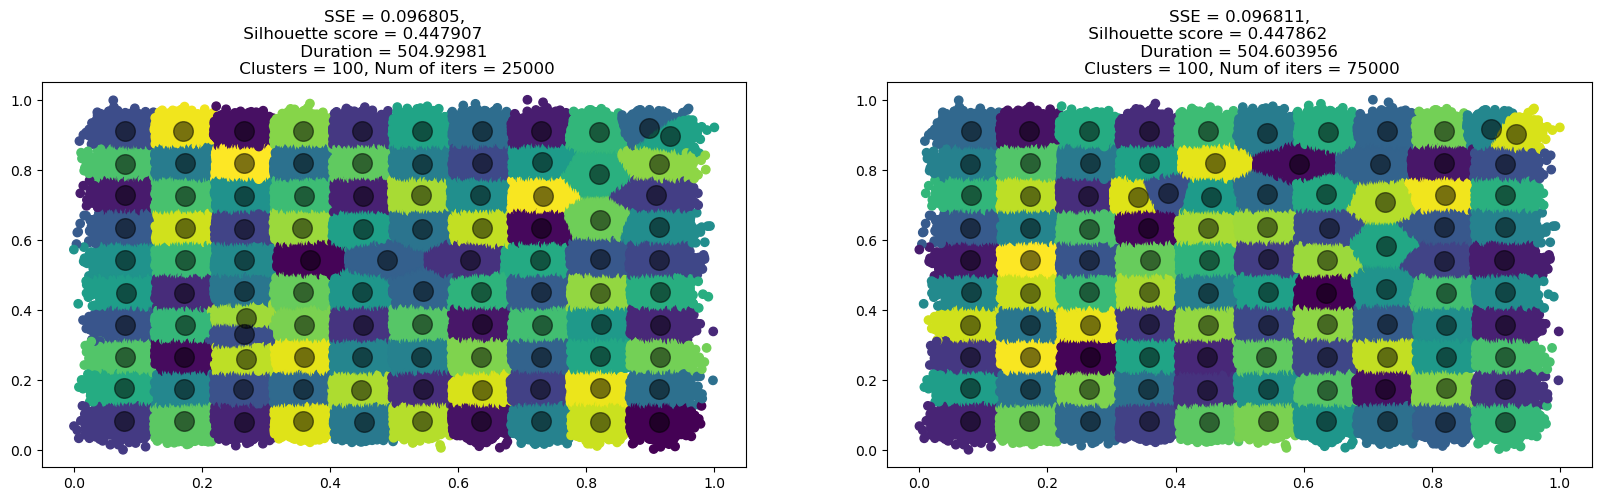

Data name =  b1.txt
Data =  100000 points in 2 dimensions
pso


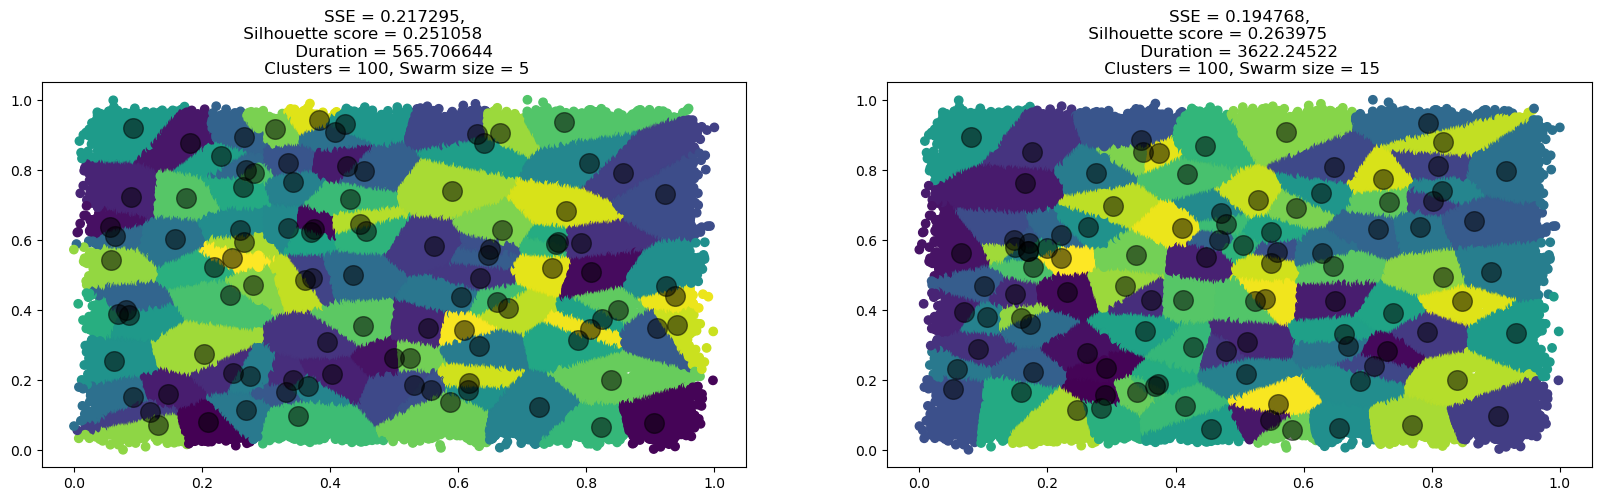

Data name =  b1.txt
Data =  100000 points in 2 dimensions
hybrid-pso


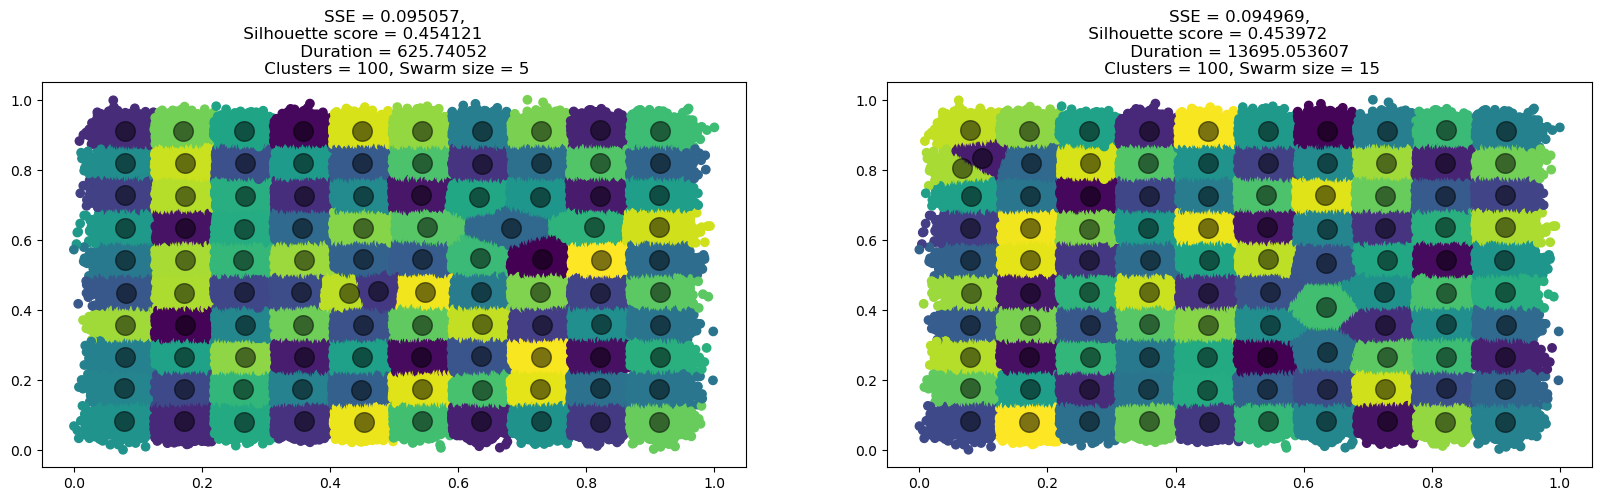

Data name =  b2.txt
Data =  100000 points in 2 dimensions
k-means


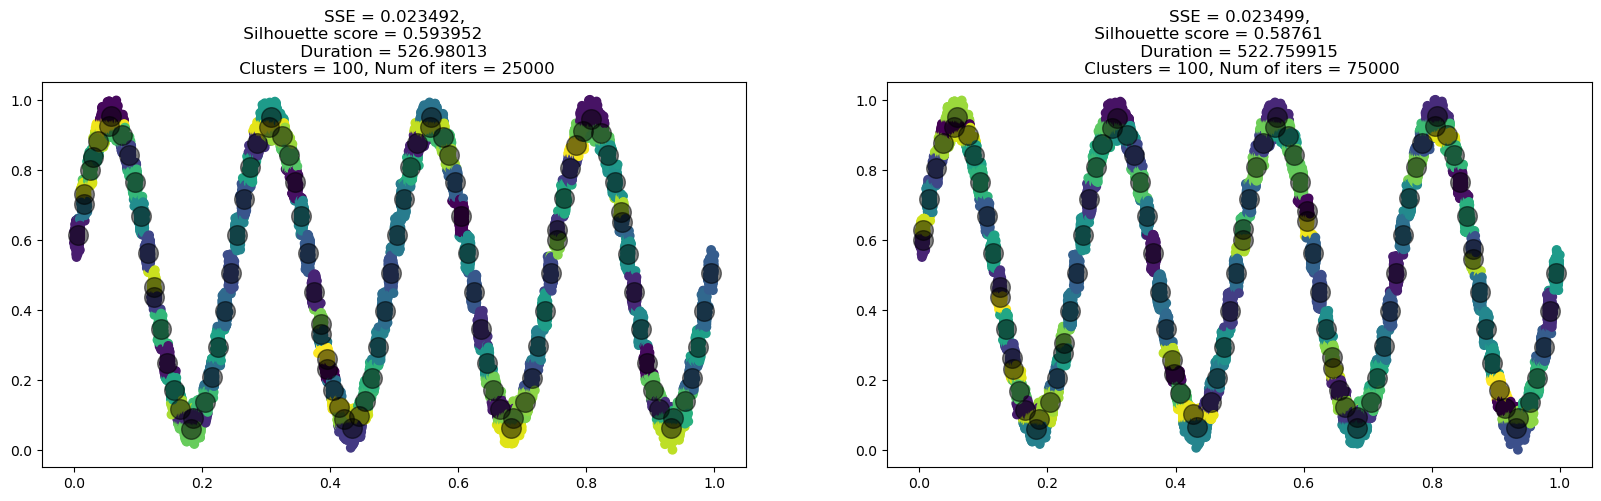

Data name =  b2.txt
Data =  100000 points in 2 dimensions
pso


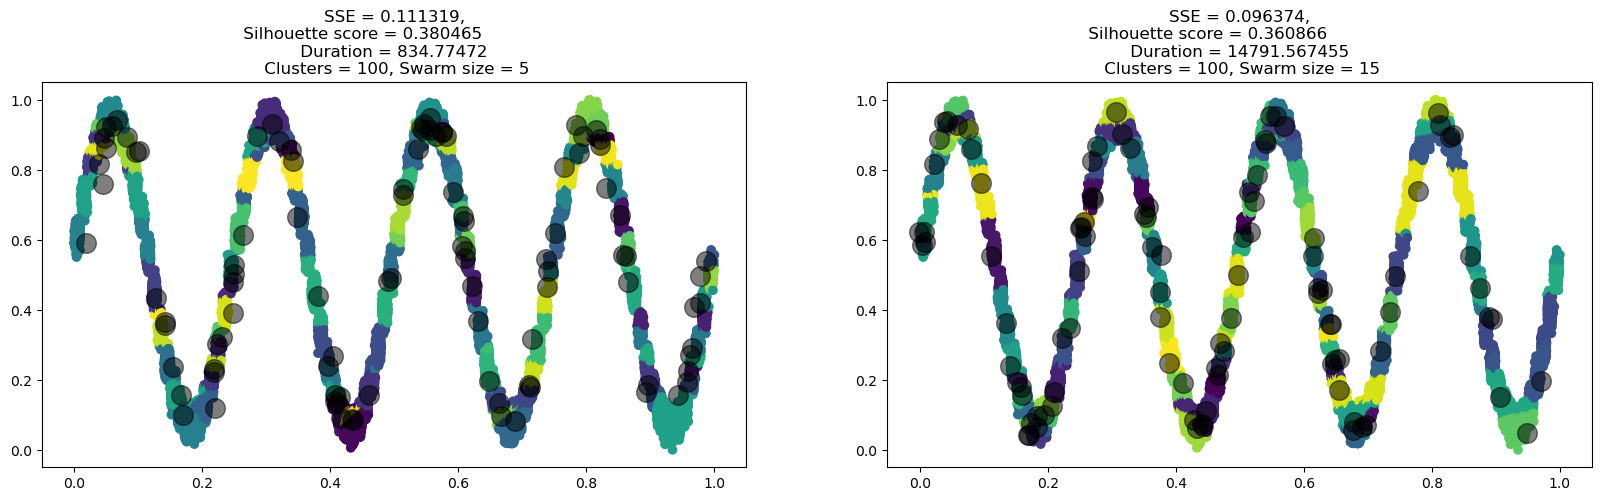

Data name =  b2.txt
Data =  100000 points in 2 dimensions
hybrid-pso


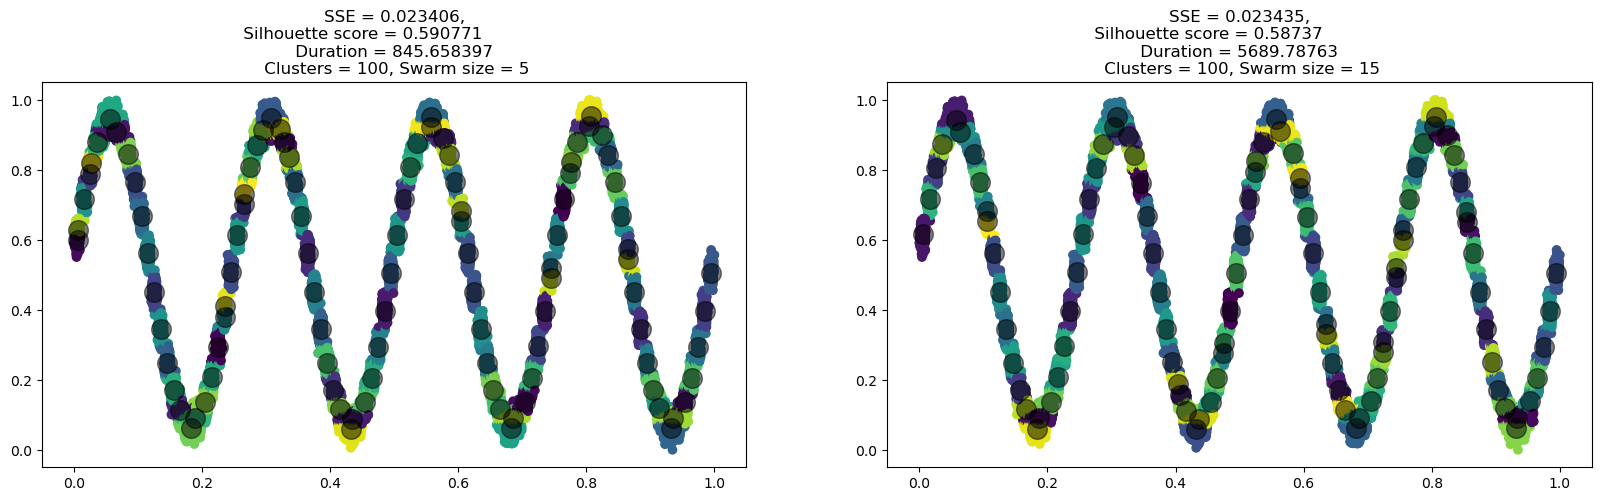

In [13]:
#ime: ([broj_klastera], [broj_cestica])
datasets = {
    'datasets/dogs.txt': ([3], [5, 10, 15], [1000]), 
    'datasets/iris.txt': ([3], [5, 10, 15], [1000]), 
    'datasets/IP.txt' : ([3,4,5,6], [5, 10, 15], [3000]),
    'datasets/s1.txt': ([15], [5, 10], [5000]),
    'datasets/s4.txt': ([35], [5, 10], [5000]),
    'datasets/b1.txt': ([100], [5, 15], [5000]),
    'datasets/b2.txt': ([100], [5, 15], [5000])
}

plot = True 

algs = ['k-means', 'agglomerative', 'pso', 'hybrid-pso']
for i in range(len(datasets)):
    if i < 3:
        separator = '\s+'
    else:
        separator = "\s+"
        
    for alg_name in algs:
        data_points = pd.read_csv(list(datasets)[i], sep=separator, header=None)
        # svim algoritmima podaci treba da su skalirani MinMaxScaler-om
        data = standardize_data(data_points)

        print('Data name = ', list(datasets)[i])
        print('Data = ', data_points.shape[0], 'points in', data_points.shape[1], 'dimensions')
        print(alg_name)
        
        cluster_values = list(datasets.values())[i][0]
        swarm_values = list(datasets.values())[i][1]
        iterations = list(datasets.values())[i][2][0]

        fig = plt.figure(figsize=(20, 5*len(cluster_values)))
        plt_index = 1
        plt.subplots_adjust(hspace = 0.4)

        for k in cluster_values:            
            for p in swarm_values: 
                fig.add_subplot(len(cluster_values),len(swarm_values), plt_index)
                
                if (alg_name == 'pso' or alg_name == 'hybrid-pso'):
                    
                    start_time = time.time()
                    pso = start_pso(alg_name, data, k, p, iterations) 
                    end_time = time.time()
                    duration = end_time - start_time
                    plot_pso(data, pso, duration, k, p)
                    
                elif (alg_name == 'k-means'):
                    
                    start_time = time.time()
                    kmeans = start_k_means(data, k, p*iterations)
                    end_time = time.time()
                    duration = end_time - start_time
                    plot_k_means(data, kmeans, duration)
                    
                else:
                    start_time = time.time()
                    model, linkage = start_agglomerative(data, k, plt_index)
                    end_time = time.time()
                    duration = end_time - start_time
                    plot_agglomerative(data, model, linkage, duration)
                       
                plt_index += 1 
            
        plt.show()